In [5]:
import warnings
warnings.filterwarnings("ignore")

import re
import json
import csv
import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Patch
from cycler import cycler

In [6]:
#rcParams default settings
"https://matplotlib.org/stable/tutorials/introductory/customizing.html"

#rcParams settings
plt.style.use('ggplot')

rcParams['font.family'] = 'sans-serif'
rcParams['font.style'] = 'normal'

rcParams['figure.facecolor'] = 'white'

rcParams['savefig.bbox'] = 'tight'
rcParams['savefig.dpi'] = 300
rcParams['savefig.transparent'] = True

rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False
rcParams['axes.labelsize'] = 20
rcParams['axes.labelcolor'] = 'black'
rcParams['axes.edgecolor'] = 'grey'
rcParams['axes.linewidth'] = 3
rcParams['axes.facecolor'] = 'white'
rcParams['axes.titlepad'] = 4
rcParams['axes.titlesize'] = 20

rcParams['xtick.color'] = 'grey'
rcParams['ytick.color'] = 'grey'
rcParams['xtick.labelsize'] = 15
rcParams['ytick.labelsize'] = 15
rcParams['xtick.major.width'] = 2
rcParams['ytick.major.width'] = 0
rcParams['xtick.major.size'] = 5
rcParams['ytick.major.size'] = 0

rcParams['lines.linewidth'] = 3
rcParams['lines.markersize'] = 10

rcParams['legend.title_fontsize'] = 15
rcParams['legend.fontsize'] = 10

rcParams['grid.color'] = 'grey'
rcParams['grid.linewidth'] = 0.1

icefire_palette = sns.color_palette("icefire")
sns.set_palette(icefire_palette)

# Functions

In [7]:
# Function to clean tweets
def preliminary_cleaning(t):              
    # Convert to lowercase
    text = t.lower()
        
    # Remove newlines, tabs, and extra whitespace
    text = text.replace('\n', ' ').replace('\t', ' ').replace('&amp;', '&').replace('&gt;', '')
    text = re.sub(r'\s+', ' ', text).strip()
    
    def remove_urls(text):
        # Define the regex pattern for URLs
        url_pattern = re.compile(r'https?://\S+|www\.\S+')
        # Use the sub method to replace URLs with an empty string
        cleaned_text = re.sub(url_pattern, '', text)
        return cleaned_text

    def remove_usernames(text):
        # Use a regular expression to find all @usernames at the beginning of the text
        cleaned_text = re.sub(r'^(@\w+\s*)+', '', text)
        return cleaned_text
    
    text = remove_urls(text)
    
    text = remove_usernames(text)
    
    return text

# Function to capitalize and replace specific usernames
def format_username(username):
    # Dictionary for specific replacements
    specific_replacements = {
        'lego_group': 'Lego Group',
        'hm': 'H&M',
        'detushepostdhl': 'DHL',
        'iberdrola_en': 'Iberdrola'
    }
    # Apply specific replacements if available
    if username in specific_replacements:
        return specific_replacements[username]
    # General case for handling 'group'
    if 'group' in username.lower():
        parts = username.split('group')
        return ' '.join([part.capitalize() for part in parts if part]) + ' Group'
    # Capitalize other usernames
    return username.capitalize()

# Reading Data

In [8]:
df = pd.read_csv("data/data_2.csv", index_col=[0])

# Cleaning Data

In [9]:
df['date'] = pd.to_datetime(df['created_at'], format='%Y-%m-%dT%H:%M:%S.%fZ')
df['week'] = df['date'].dt.isocalendar().week
df['month'] = df['date'].dt.month
df.username = df.username.apply(lambda x: format_username(x))

In [10]:
#subset of columns to analyze text
texts_df = df[['username', 'created_at', 'text', 'lang']]

###### Plot Palette Setting

In [11]:
icefire_palette = sns.color_palette("icefire", n_colors=len(df.username.unique()))
tab20_palette = sns.color_palette("tab20", n_colors=20)
tab10_palette = sns.color_palette("tab10", n_colors=10)

# Activity over time analysis

#### Total number of tweets

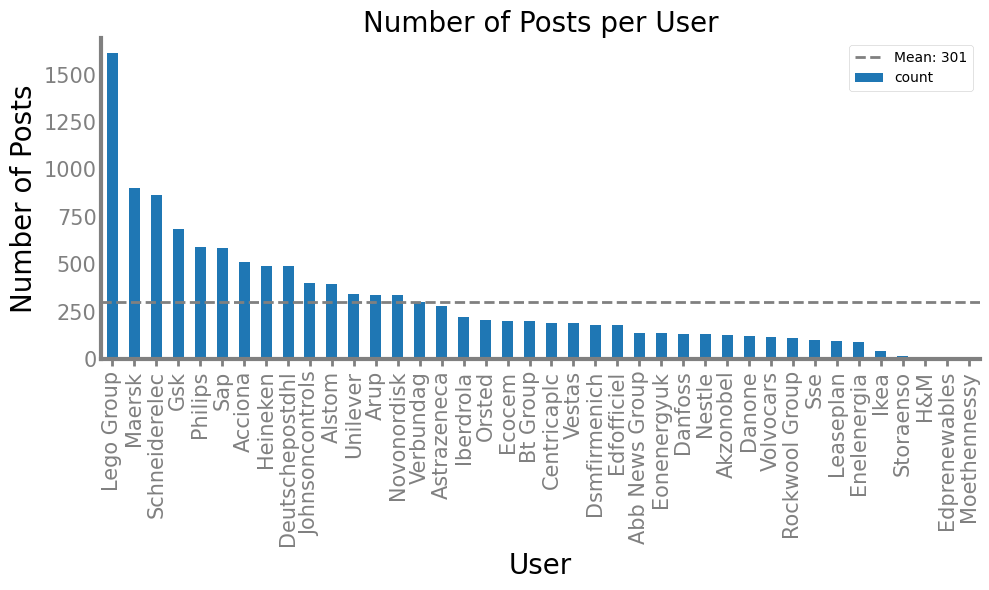

In [12]:
tweet_counts = df['username'].value_counts()
average_posts = tweet_counts.mean()

plt.figure(figsize=(10, 6))
tweet_counts.plot(kind='bar', color='tab:blue')
plt.axhline(y=average_posts, color='grey', linestyle='--', linewidth=2, label=f'Mean: {average_posts:.0f}')
plt.title('Number of Posts per User')
plt.xlabel('User')
plt.ylabel('Number of Posts')
plt.xticks(rotation=90)  # Apply formatted labels
plt.legend()
plt.grid(False)
plt.tight_layout()
plotname = '../data/out/figures/number_posts_per_user.png'
plt.savefig(plotname, dpi=600, bbox_inches='tight', facecolor='white')

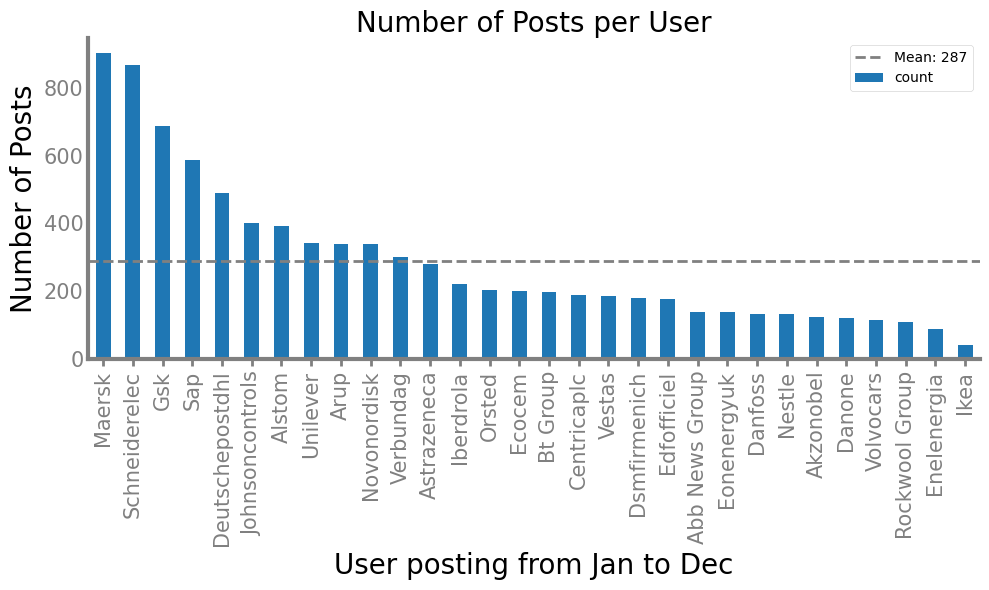

In [13]:
first_last_posts = df.groupby('username')['date'].agg(['min', 'max'])
first_last_posts = first_last_posts[(first_last_posts['min'].dt.month == 1) & (first_last_posts['max'].dt.month == 12)]
filtered_df = df[df['username'].isin(first_last_posts.index)]
tweet_counts = filtered_df['username'].value_counts()
average_posts = tweet_counts.mean()

plt.figure(figsize=(10, 6))
tweet_counts.plot(kind='bar', color='tab:blue')
plt.axhline(y=average_posts, color='grey', linestyle='--', linewidth=2, label=f'Mean: {average_posts:.0f}')
plt.title('Number of Posts per User')
plt.xlabel('User posting from Jan to Dec')
plt.ylabel('Number of Posts')
plt.xticks(rotation=90)  # Apply formatted labels
plt.legend()
plt.grid(False)
plt.tight_layout()

plotname = '../data/out/figures/number_posts_per_user_filtered.png'
plt.savefig(plotname, dpi=600, bbox_inches='tight', facecolor='white')

#### Daily tweet distribution

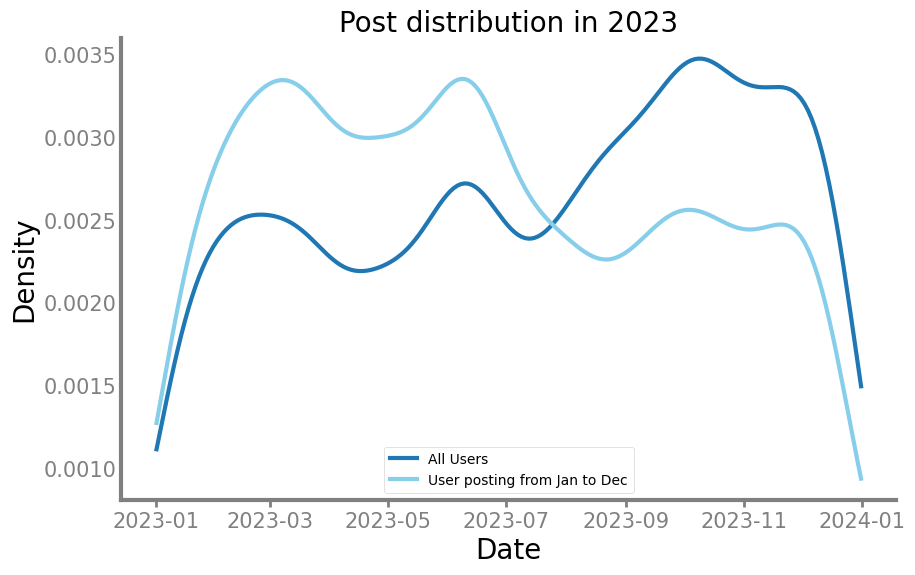

In [14]:
tweet_counts = filtered_df['username'].value_counts()
tweet_counts.index.to_list()

_, ax = plt.subplots(figsize=(10, 6))

# Create the KDE plot without the legend
sns.kdeplot(data=df, x="date", cut=0, ax = ax, color='tab:blue', label='All Users')
sns.kdeplot(data=filtered_df, x="date", cut=0, ax = ax, color='skyblue', label='User posting from Jan to Dec')

# Set x and y tick labels font size
plt.xlabel('Date')
plt.title('Post distribution in 2023')
plt.legend()
plt.grid(False)

plotname = '../data/out/figures/post_number_distribution_2023.png'
plt.savefig(plotname, dpi=600, bbox_inches='tight', facecolor='white')

###### Alstom

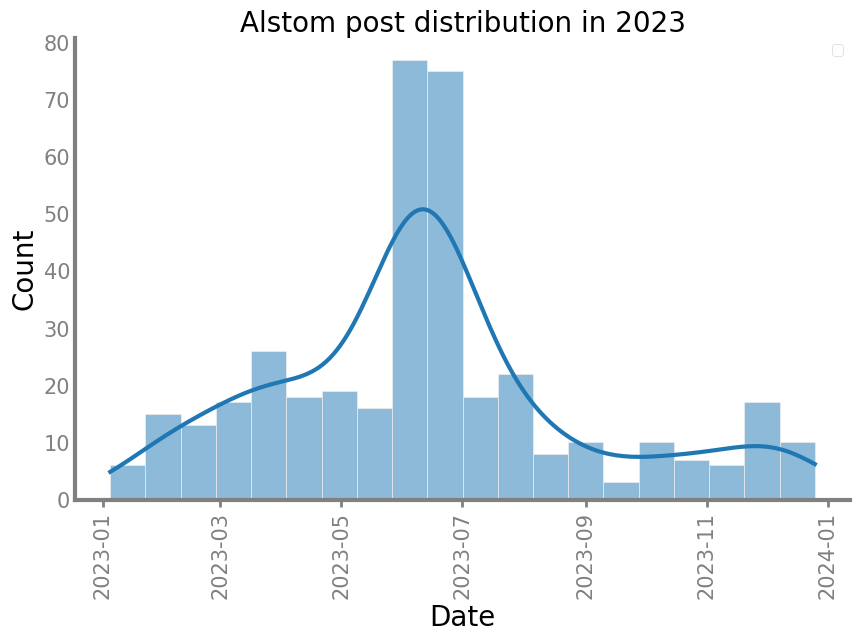

In [15]:
tmp = df.loc[df.username == 'Alstom']

_, ax = plt.subplots(figsize=(10, 6))
sns.histplot(data=tmp, x="date", ax = ax, color='tab:blue', bins=20, kde=True, kde_kws={'cut':0})

plt.xticks(rotation=90)
plt.xlabel('Date')
plt.title('Alstom post distribution in 2023')
plt.legend()
plt.grid(False)

plotname = '../data/out/figures/post_number_distribution_Alstom_2023.png'
plt.savefig(plotname, dpi=600, bbox_inches='tight', facecolor='white')

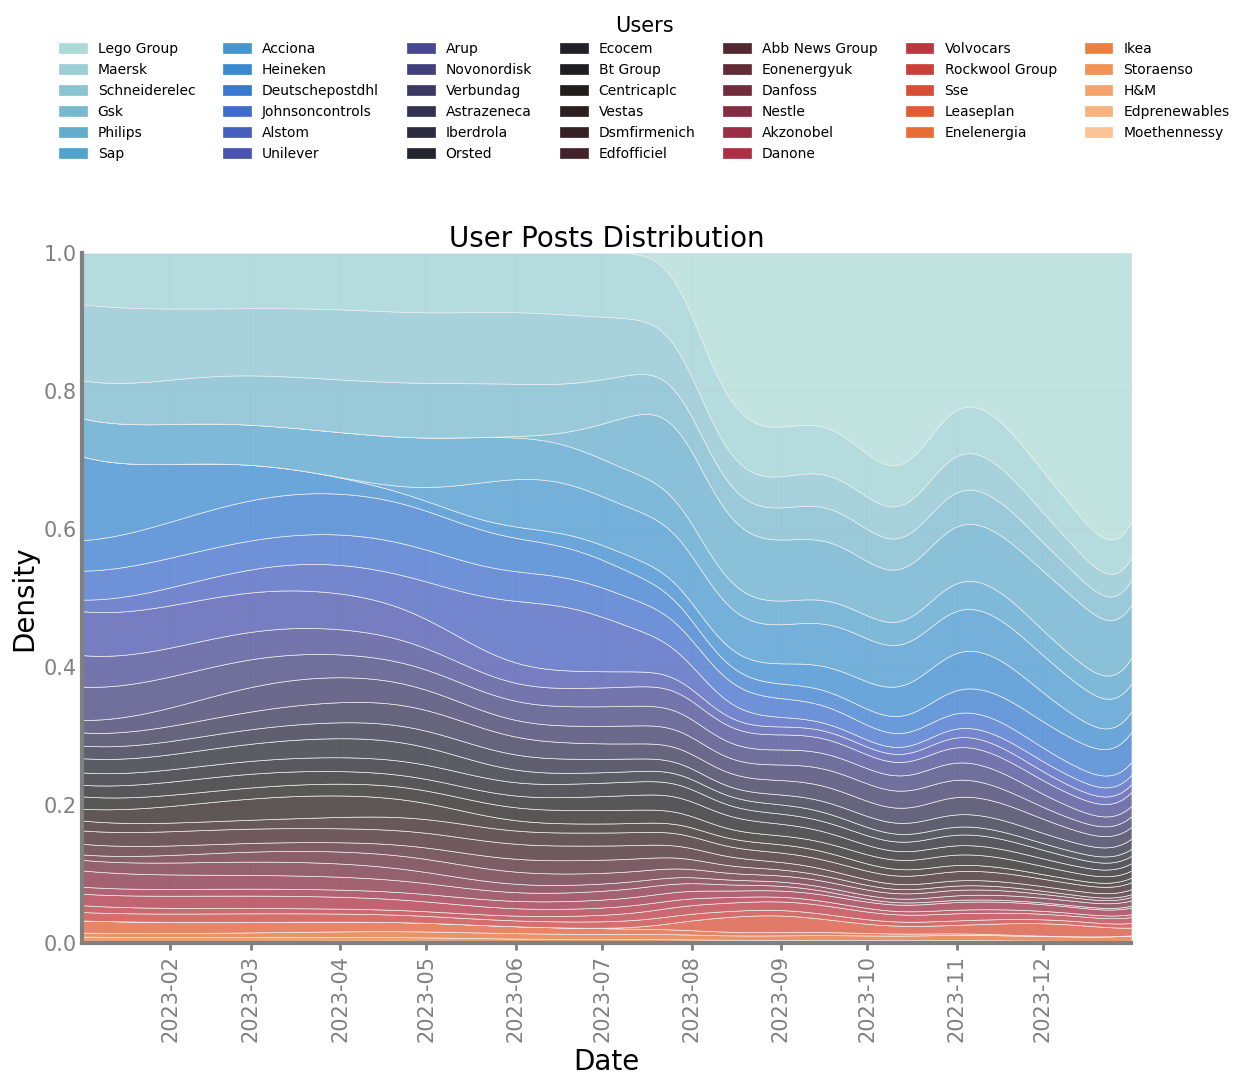

In [16]:
tweet_counts = df['username'].value_counts()
sorted_usernames = tweet_counts.index.to_list()

_, ax = plt.subplots(ncols=2, figsize=(15, 10), width_ratios=(30,0.2))
g = sns.kdeplot(data=df, x="date", hue="username",  hue_order = sorted_usernames, multiple='fill', legend=False, cut=0, ax=ax[0], palette=icefire_palette)
ax[0].set_xticks(ticks=ax[0].get_xticks(), labels = ax[0].get_xticklabels(), rotation=90)
ax[0].set_yticks(ticks=ax[0].get_yticks(),  labels = ax[0].get_yticklabels())
ax[0].set_xlabel('Date')
ax[0].set_title('User Posts Distribution')
handles = [Patch(color=icefire_palette[i], label=sorted_usernames[i]) for i in range(len(sorted_usernames))]
labels = sorted_usernames
fig = plt.gcf()
fig_width = fig.get_size_inches()[0]  # Width of the figure in inches
max_legend_columns = int(fig_width // 2)  # Adjust the divisor to control column width
n_columns = min(len(sorted_usernames), max_legend_columns)
plt.subplots_adjust(top=0.8)  # Increase top margin
fig.legend(labels = labels, handles=handles, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=n_columns, frameon=False, title = 'Users', title_fontsize=15)
ax[1].axis("off")

plotname = '../data/out/figures/post_number_distribution_2023_by_user.png'
plt.savefig(plotname, dpi=600, bbox_inches='tight', facecolor='white')

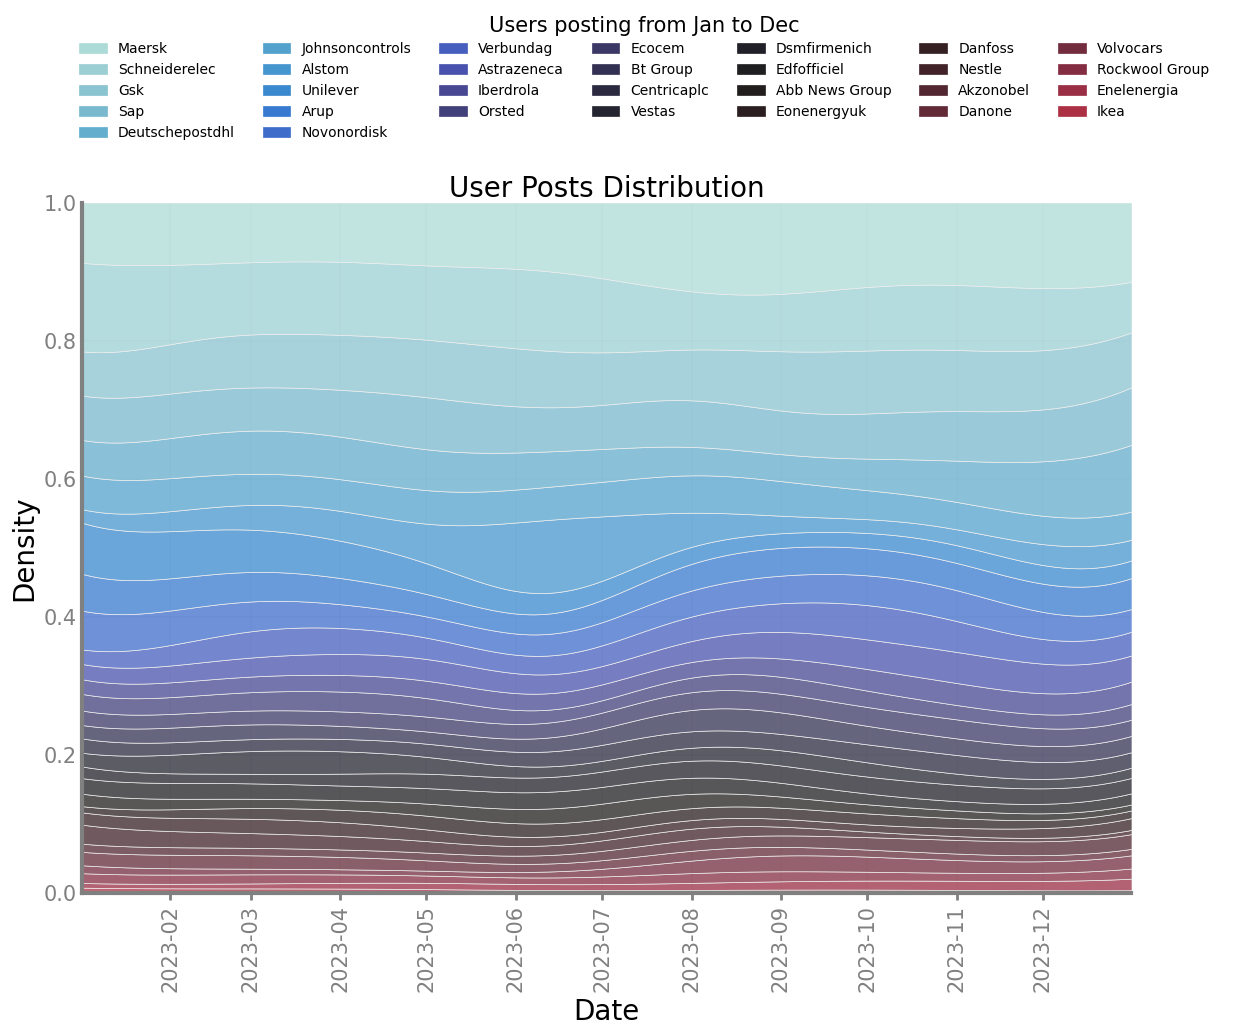

In [17]:
tweet_counts = filtered_df['username'].value_counts()
sorted_usernames = tweet_counts.index.to_list()

_, ax = plt.subplots(ncols=2, figsize=(15, 10), width_ratios=(30,0.2))
g = sns.kdeplot(data=filtered_df, x="date", hue="username",  hue_order = sorted_usernames, multiple='fill', legend=False, cut=0, ax=ax[0], palette=icefire_palette)
ax[0].set_xticks(ticks=ax[0].get_xticks(), labels = ax[0].get_xticklabels(), rotation=90)
ax[0].set_yticks(ticks=ax[0].get_yticks(),  labels = ax[0].get_yticklabels())
ax[0].set_xlabel('Date')
ax[0].set_title('User Posts Distribution')
handles = [Patch(color=icefire_palette[i], label=sorted_usernames[i]) for i in range(len(sorted_usernames))]
labels = sorted_usernames
fig = plt.gcf()
fig_width = fig.get_size_inches()[0]  # Width of the figure in inches
max_legend_columns = int(fig_width // 2)  # Adjust the divisor to control column width
n_columns = min(len(sorted_usernames), max_legend_columns)
plt.subplots_adjust(top=0.8)  # Increase top margin
fig.legend(labels = labels, handles=handles, loc='upper center', bbox_to_anchor=(0.5, 1), ncol=n_columns, frameon=False, title = 'Users posting from Jan to Dec')
ax[1].axis("off")

plotname = '../data/out/figures/post_number_distribution_2023_by_user_filtered.png'
plt.savefig(plotname, dpi=600, bbox_inches='tight', facecolor='white')

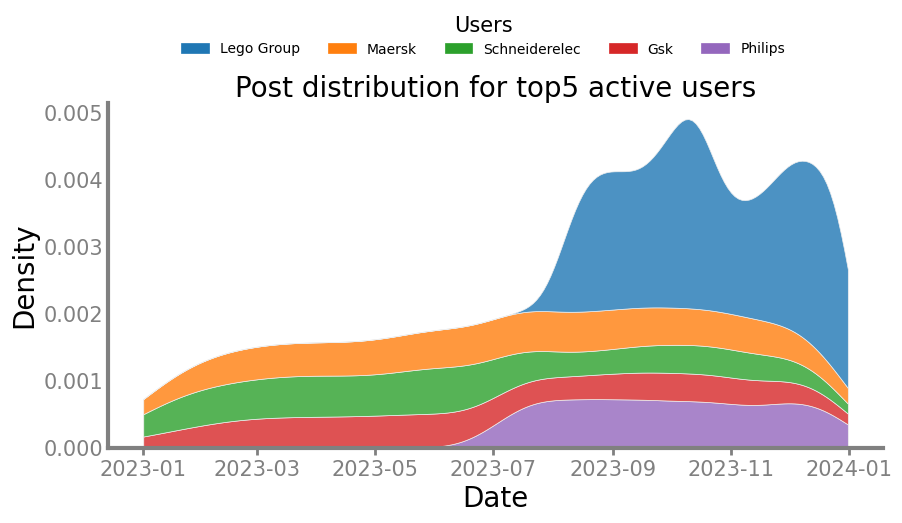

In [18]:
plot_df = df.copy()

_, ax = plt.subplots(figsize=(10, 5))
tweet_counts = plot_df['username'].value_counts()
sorted_usernames = tweet_counts.index.to_list()

sns.kdeplot(data=plot_df.loc[plot_df.username.isin(sorted_usernames[:5])], x="date", cut=0, ax = ax, hue='username', multiple='stack', alpha=0.8, legend=False, hue_order=sorted_usernames[:5], palette=tab10_palette)
plt.xlabel('Date')
plt.title('Post distribution for top5 active users')
plt.grid(False)

handles = [Patch(color=tab10_palette[i], label=sorted_usernames[i]) for i in range(len(sorted_usernames[:5]))]
labels = sorted_usernames[:5]
fig = plt.gcf()
fig_width = fig.get_size_inches()[0]  # Width of the figure in inches
max_legend_columns = int(fig_width // 2)  # Adjust the divisor to control column width
n_columns = min(len(sorted_usernames), max_legend_columns)
plt.subplots_adjust(top=0.8)  # Increase top margin
fig.legend(labels = labels, handles=handles, loc='upper center', bbox_to_anchor=(0.5, 1), ncol=n_columns, frameon=False, title = 'Users')

plotname = '../data/out/figures/post_number_distribution_2023_top5.png'
plt.savefig(plotname, dpi=600, bbox_inches='tight', facecolor='white')

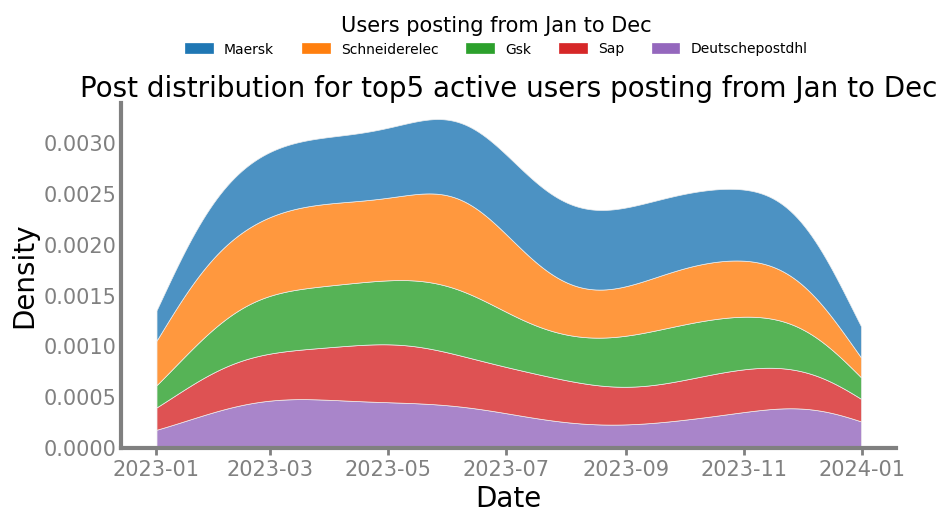

In [19]:
plot_df = filtered_df.copy()

_, ax = plt.subplots(figsize=(10, 5))
tweet_counts = plot_df['username'].value_counts()
sorted_usernames = tweet_counts.index.to_list()

sns.kdeplot(data=plot_df.loc[plot_df.username.isin(sorted_usernames[:5])], x="date", cut=0, ax = ax, hue='username', multiple='stack', alpha=0.8, legend=False, hue_order=sorted_usernames[:5], palette=tab10_palette)
plt.xlabel('Date')
plt.title('Post distribution for top5 active users posting from Jan to Dec')
plt.grid(False)

handles = [Patch(color=tab10_palette[i], label=sorted_usernames[i]) for i in range(len(sorted_usernames[:5]))]
labels = sorted_usernames[:5]
fig = plt.gcf()
fig_width = fig.get_size_inches()[0]  # Width of the figure in inches
max_legend_columns = int(fig_width // 2)  # Adjust the divisor to control column width
n_columns = min(len(sorted_usernames), max_legend_columns)
plt.subplots_adjust(top=0.8)  # Increase top margin
fig.legend(labels = labels, handles=handles, loc='upper center', bbox_to_anchor=(0.5, 1), ncol=n_columns, frameon=False, title = 'Users posting from Jan to Dec')

plotname = '../data/out/figures/post_number_distribution_2023_top5_filtered.png'
plt.savefig(plotname, dpi=600, bbox_inches='tight', facecolor='white')

#### Weekly trends

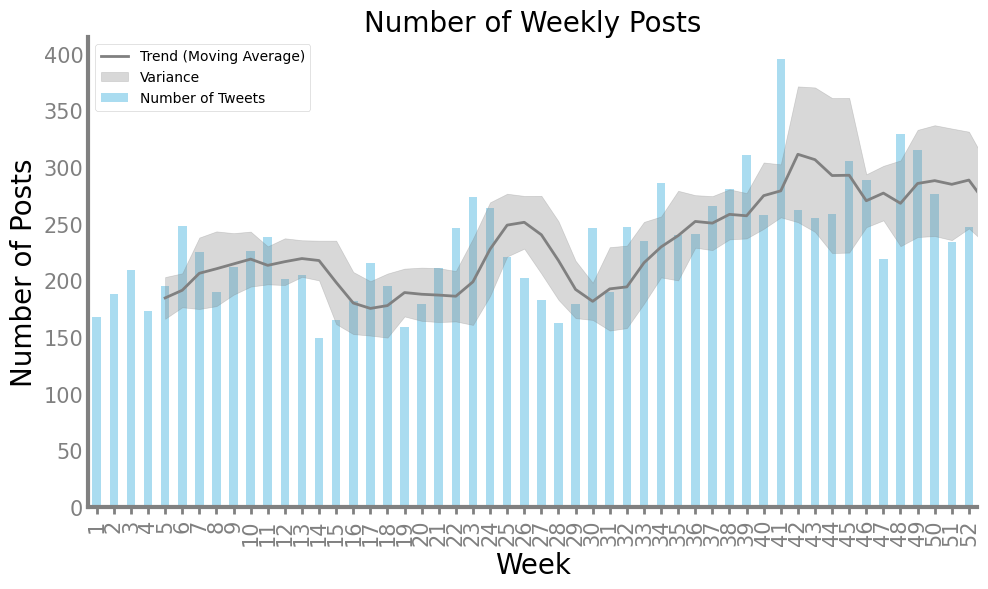

In [20]:
df_plot = df.groupby(['week']).size()

# Plot the barplot
plt.figure(figsize=(10, 6))
df_plot.plot(kind='bar', color='skyblue', alpha=0.7, label='Number of Tweets')

window_size = 4 
maverage = df_plot.rolling(window=window_size).mean()
std_dev = df_plot.rolling(window=window_size).std()
plt.plot(maverage, color='grey', linewidth=2, label='Trend (Moving Average)')
plt.fill_between(df_plot.index.to_list(), maverage-std_dev, maverage+std_dev, color='grey', alpha=0.3, label='Variance')

plt.title('Number of Weekly Posts')
plt.xlabel('Week')
plt.ylabel('Number of Posts')
plt.grid(False)
plt.tight_layout()
plt.legend()

plotname = '../data/out/figures/weekly_post_distribution_2023.png'
plt.savefig(plotname, dpi=600, bbox_inches='tight', facecolor='white')

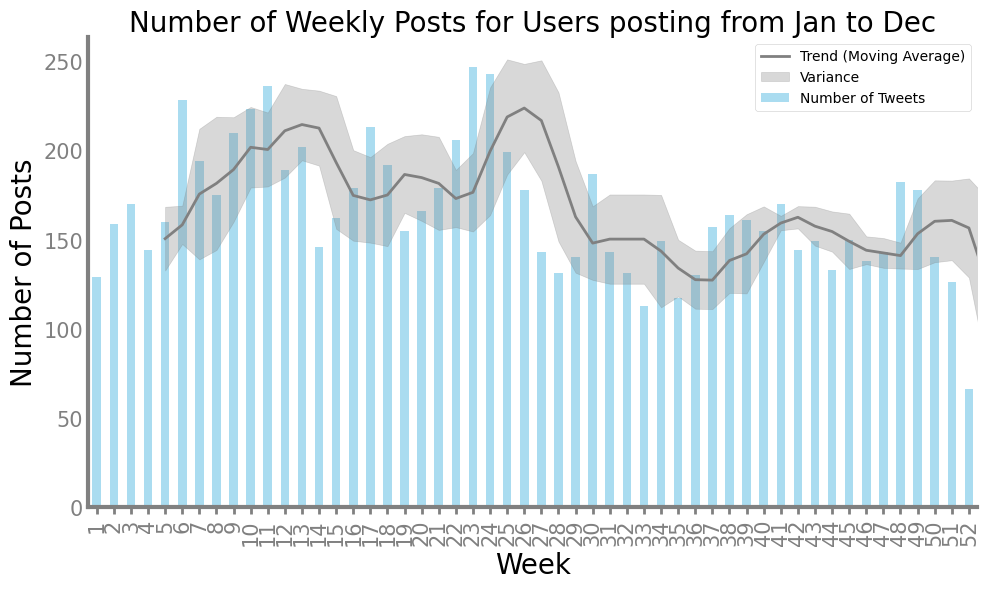

In [21]:
df_plot = filtered_df.groupby(['week']).size()

# Plot the barplot
plt.figure(figsize=(10, 6))
df_plot.plot(kind='bar', color='skyblue', alpha=0.7, label='Number of Tweets')

window_size = 4 
maverage = df_plot.rolling(window=window_size).mean()
std_dev = df_plot.rolling(window=window_size).std()
plt.plot(maverage, color='grey', linewidth=2, label='Trend (Moving Average)')
plt.fill_between(df_plot.index.to_list(), maverage-std_dev, maverage+std_dev, color='grey', alpha=0.3, label='Variance')

plt.title('Number of Weekly Posts for Users posting from Jan to Dec')
plt.xlabel('Week')
plt.ylabel('Number of Posts')
plt.grid(False)
plt.tight_layout()
plt.legend()

plotname = '../data/out/figures/weekly_post_distribution_2023_filtered.png'
plt.savefig(plotname, dpi=600, bbox_inches='tight', facecolor='white')

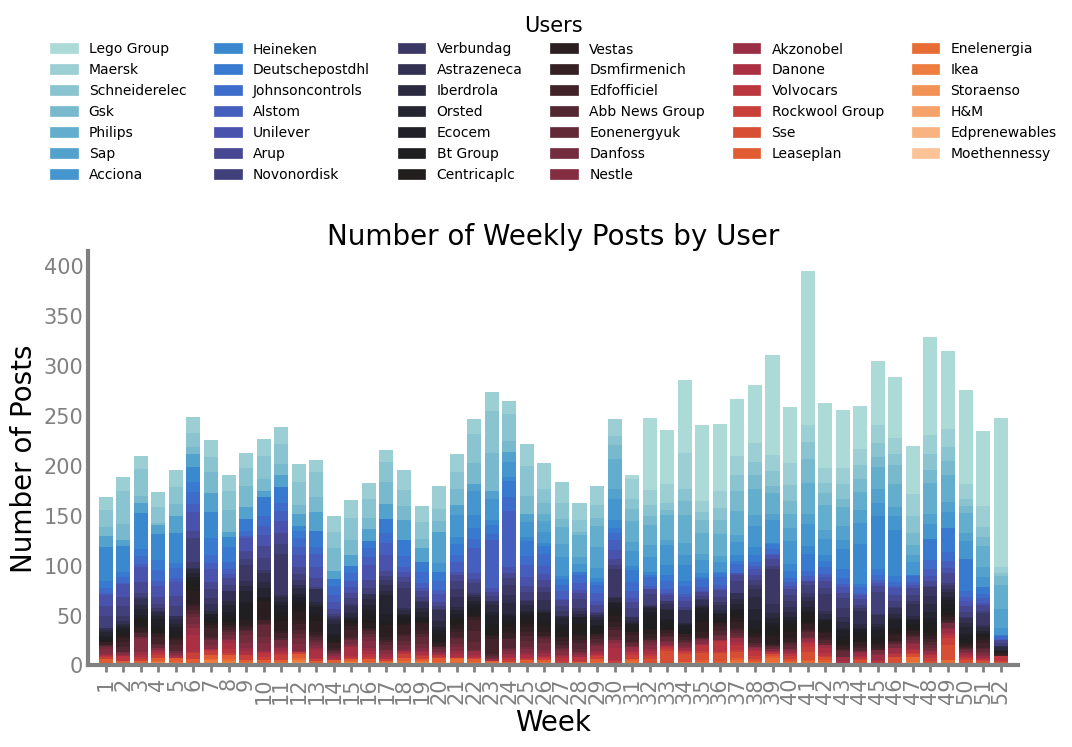

In [22]:
# Assuming 'df' is already defined and 'date' column is in datetime format
tmp = df.groupby(['week']).size()
df_plot = df.groupby(['week', 'username']).size().reset_index().pivot(columns='username', index='week', values=0)
df_plot = df_plot.fillna(value=0)
sorted_usernames = df.username.value_counts().index.to_list()

_, ax = plt.subplots(figsize=(12, 6))
for i in range(len(sorted_usernames)-1, -1, -1):
    if i == len(sorted_usernames)-1:
        ax.bar(x = df_plot[sorted_usernames[i]].index, height = df_plot[sorted_usernames[i]].values, color=icefire_palette[i])
        bottom = df_plot[sorted_usernames[i]].values.copy()
    else:
        ax.bar(x = df_plot[sorted_usernames[i]].index, height = df_plot[sorted_usernames[i]].values, bottom = bottom, color=icefire_palette[i])
        bottom += df_plot[sorted_usernames[i]].values.copy()

plt.title('Number of Weekly Posts by User')
plt.xlabel('Week')
plt.ylabel('Number of Posts')
plt.xticks(ticks = df_plot.index.to_list(), rotation=90)
plt.xlim(0,53)
plt.grid(False)

# tmp = df.groupby(['week']).size()
# window_size = 4 
# maverage = tmp.rolling(window=window_size).mean()
# std_dev = tmp.rolling(window=window_size).std()
# plt.plot(maverage, color='grey', linewidth=2, label='Trend (Moving Average)')
# plt.fill_between(tmp.index.to_list(), maverage-std_dev, maverage+std_dev, color='grey', alpha=0.3, label='Variance')

plt.subplots_adjust(top=0.8)  # Increase top margin
handles = [Patch(color=icefire_palette[i], label=sorted_usernames[i]) for i in range(len(sorted_usernames))]
labels = sorted_usernames
plt.legend(labels = labels, handles=handles, loc='upper center', bbox_to_anchor=(0.5, 1.6), ncol=6, frameon=False, title = 'Users')

plotname = '../data/out/figures/weekly_post_distribution_2023_by_user.png'
plt.savefig(plotname, dpi=600, bbox_inches='tight', facecolor='white')

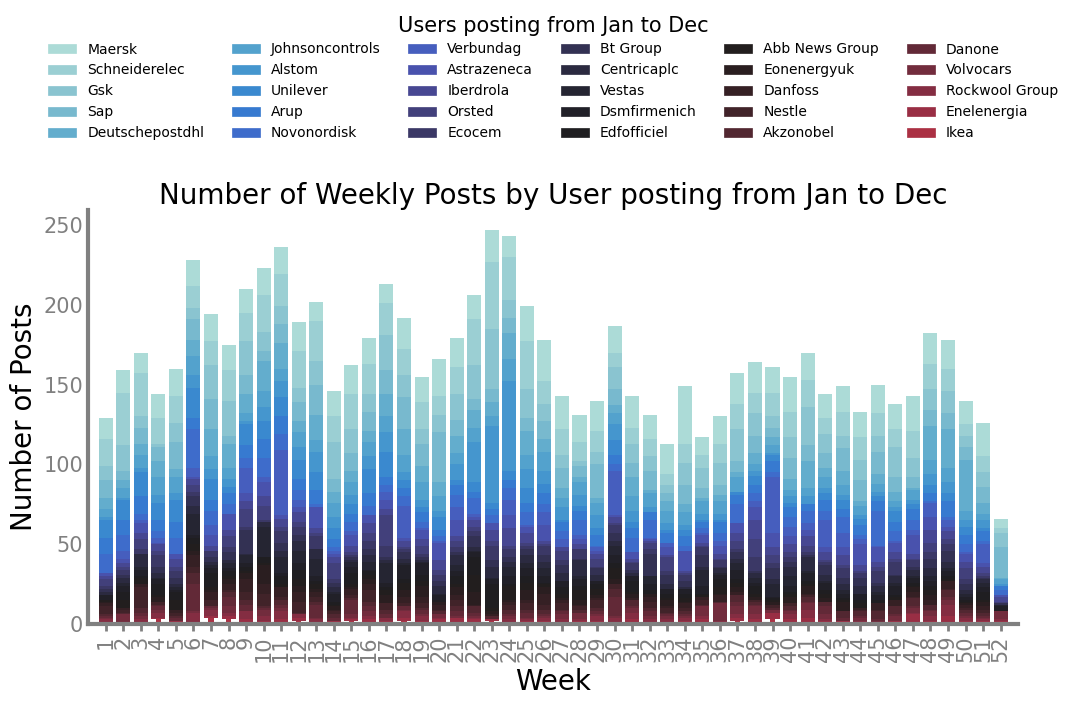

In [23]:
# Assuming 'df' is already defined and 'date' column is in datetime format
tmp = filtered_df.groupby(['week']).size()
df_plot = filtered_df.groupby(['week', 'username']).size().reset_index().pivot(columns='username', index='week', values=0)
df_plot = df_plot.fillna(value=0)
sorted_usernames = filtered_df.username.value_counts().index.to_list()

_, ax = plt.subplots(figsize=(12, 6))
for i in range(len(sorted_usernames)-1, -1, -1):
    if i == len(sorted_usernames)-1:
        ax.bar(x = df_plot[sorted_usernames[i]].index, height = df_plot[sorted_usernames[i]].values, width=0.3, color=icefire_palette[i])
        bottom = df_plot[sorted_usernames[i]].values.copy()
    else:
        ax.bar(x = df_plot[sorted_usernames[i]].index, height = df_plot[sorted_usernames[i]].values, bottom = bottom, width=0.8, color=icefire_palette[i])
        bottom += df_plot[sorted_usernames[i]].values.copy()

plt.title('Number of Weekly Posts by User posting from Jan to Dec')
plt.xlabel('Week')
plt.ylabel('Number of Posts')
plt.xticks(ticks = df_plot.index.to_list(), rotation=90)
plt.xlim(0,53)
plt.grid(False)

# tmp = df.groupby(['week']).size()
# window_size = 4 
# maverage = tmp.rolling(window=window_size).mean()
# std_dev = tmp.rolling(window=window_size).std()
# plt.plot(maverage, color='grey', linewidth=2, label='Trend (Moving Average)')
# plt.fill_between(tmp.index.to_list(), maverage-std_dev, maverage+std_dev, color='grey', alpha=0.3, label='Variance')

plt.subplots_adjust(top=0.8)  # Increase top margin
handles = [Patch(color=icefire_palette[i], label=sorted_usernames[i]) for i in range(len(sorted_usernames))]
labels = sorted_usernames
plt.legend(labels = labels, handles=handles, loc='upper center', bbox_to_anchor=(0.5, 1.5), ncol=6, frameon=False, title = 'Users posting from Jan to Dec')

plotname = '../data/out/figures/weekly_post_distribution_2023_by_user_filtered.png'
plt.savefig(plotname, dpi=600, bbox_inches='tight', facecolor='white')

#### Monthly trends

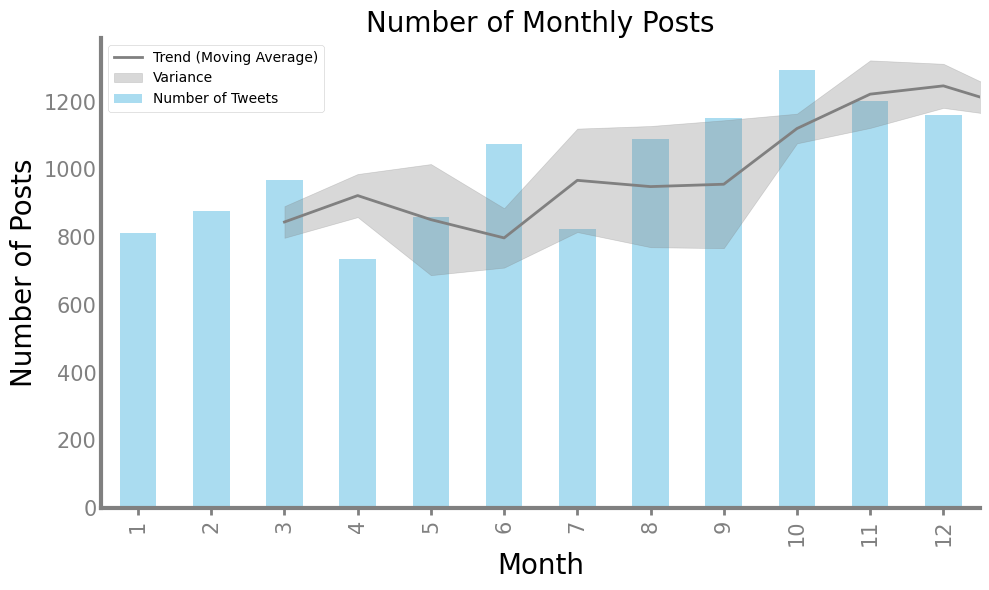

In [24]:
df_plot = df.groupby(['month']).size()

# Plot the barplot
plt.figure(figsize=(10, 6))
df_plot.plot(kind='bar', color='skyblue', alpha=0.7, label='Number of Tweets')

window_size = 2
maverage = df_plot.rolling(window=window_size).mean()
std_dev = df_plot.rolling(window=window_size).std()
plt.plot(maverage, color='grey', linewidth=2, label='Trend (Moving Average)')
plt.fill_between(df_plot.index.to_list(), maverage-std_dev, maverage+std_dev, color='grey', alpha=0.3, label='Variance')

plt.title('Number of Monthly Posts')
plt.xlabel('Month')
plt.ylabel('Number of Posts')
plt.grid(False)
plt.tight_layout()
plt.legend()

plotname = '../data/out/figures/monthly_post_distribution_2023.png'
plt.savefig(plotname, dpi=600, bbox_inches='tight', facecolor='white')

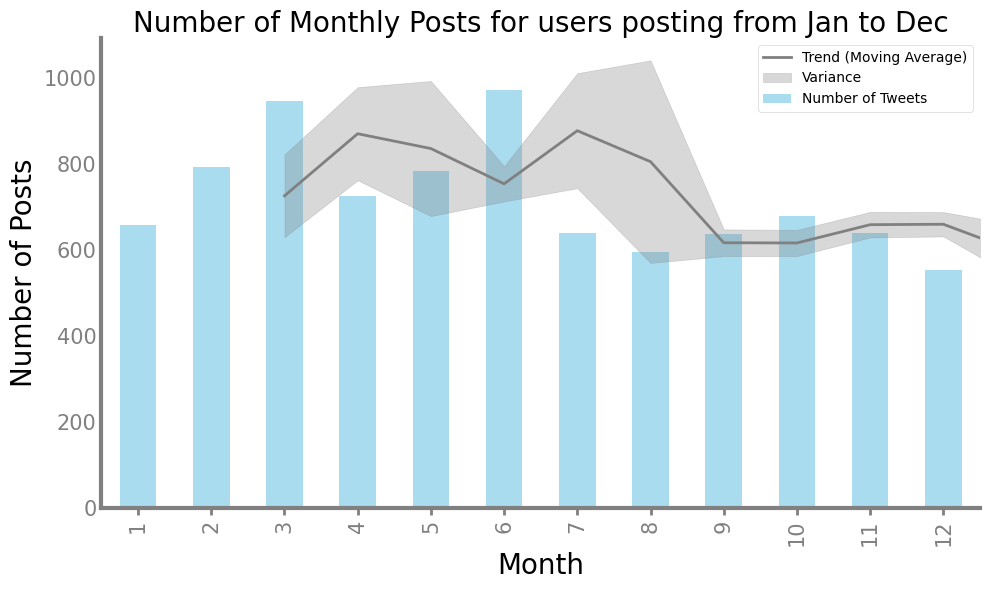

In [25]:
df_plot = filtered_df.groupby(['month']).size()

# Plot the barplot
plt.figure(figsize=(10, 6))
df_plot.plot(kind='bar', color='skyblue', alpha=0.7, label='Number of Tweets')

window_size = 2
maverage = df_plot.rolling(window=window_size).mean()
std_dev = df_plot.rolling(window=window_size).std()
plt.plot(maverage, color='grey', linewidth=2, label='Trend (Moving Average)')
plt.fill_between(df_plot.index.to_list(), maverage-std_dev, maverage+std_dev, color='grey', alpha=0.3, label='Variance')

plt.title('Number of Monthly Posts for users posting from Jan to Dec')
plt.xlabel('Month')
plt.ylabel('Number of Posts')
plt.grid(False)
plt.tight_layout()
plt.legend()

plotname = '../data/out/figures/monthly_post_distribution_2023_filtered.png'
plt.savefig(plotname, dpi=600, bbox_inches='tight', facecolor='white')



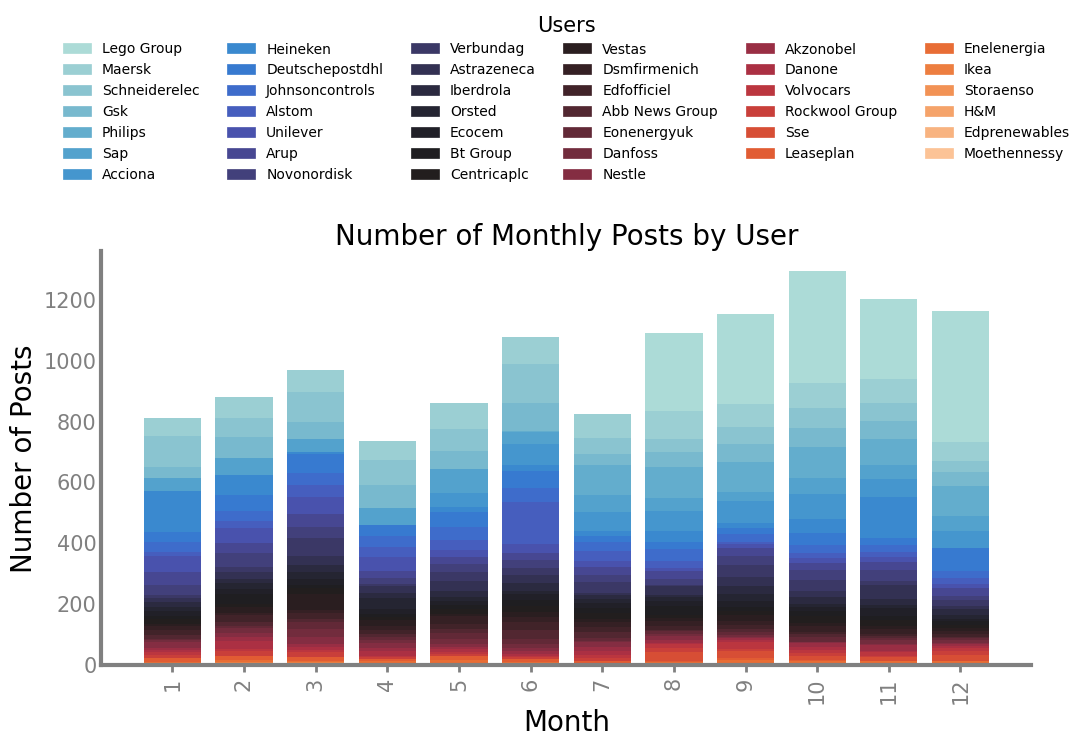

In [26]:
# Assuming 'df' is already defined and 'date' column is in datetime format
tmp = df.groupby(['month']).size()
df_plot = df.groupby(['month', 'username']).size().reset_index().pivot(columns='username', index='month', values=0)
df_plot = df_plot.fillna(value=0)
sorted_usernames = df.username.value_counts().index.to_list()

_, ax = plt.subplots(figsize=(12, 6))
for i in range(len(sorted_usernames)-1, -1, -1):
    if i == len(sorted_usernames)-1:
        ax.bar(x = df_plot[sorted_usernames[i]].index, height = df_plot[sorted_usernames[i]].values, width=0.3, color=icefire_palette[i])
        bottom = df_plot[sorted_usernames[i]].values.copy()
    else:
        ax.bar(x = df_plot[sorted_usernames[i]].index, height = df_plot[sorted_usernames[i]].values, bottom = bottom, width=0.8, color=icefire_palette[i])
        bottom += df_plot[sorted_usernames[i]].values.copy()

plt.title('Number of Monthly Posts by User')
plt.xlabel('Month')
plt.ylabel('Number of Posts')
plt.xticks(ticks = df_plot.index.to_list(), rotation=90)
plt.grid(False)

# tmp = df.groupby(['week']).size()
# window_size = 4 
# maverage = tmp.rolling(window=window_size).mean()
# std_dev = tmp.rolling(window=window_size).std()
# plt.plot(maverage, color='grey', linewidth=2, label='Trend (Moving Average)')
# plt.fill_between(tmp.index.to_list(), maverage-std_dev, maverage+std_dev, color='grey', alpha=0.3, label='Variance')

plt.subplots_adjust(top=0.8)  # Increase top margin
handles = [Patch(color=icefire_palette[i], label=sorted_usernames[i]) for i in range(len(sorted_usernames))]
labels = sorted_usernames
plt.legend(labels = labels, handles=handles, loc='upper center', bbox_to_anchor=(0.5, 1.6), ncol=6, frameon=False, title = 'Users')

plotname = '../data/out/figures/monthly_post_distribution_2023_by_user.png'
plt.savefig(plotname, dpi=600, bbox_inches='tight', facecolor='white')

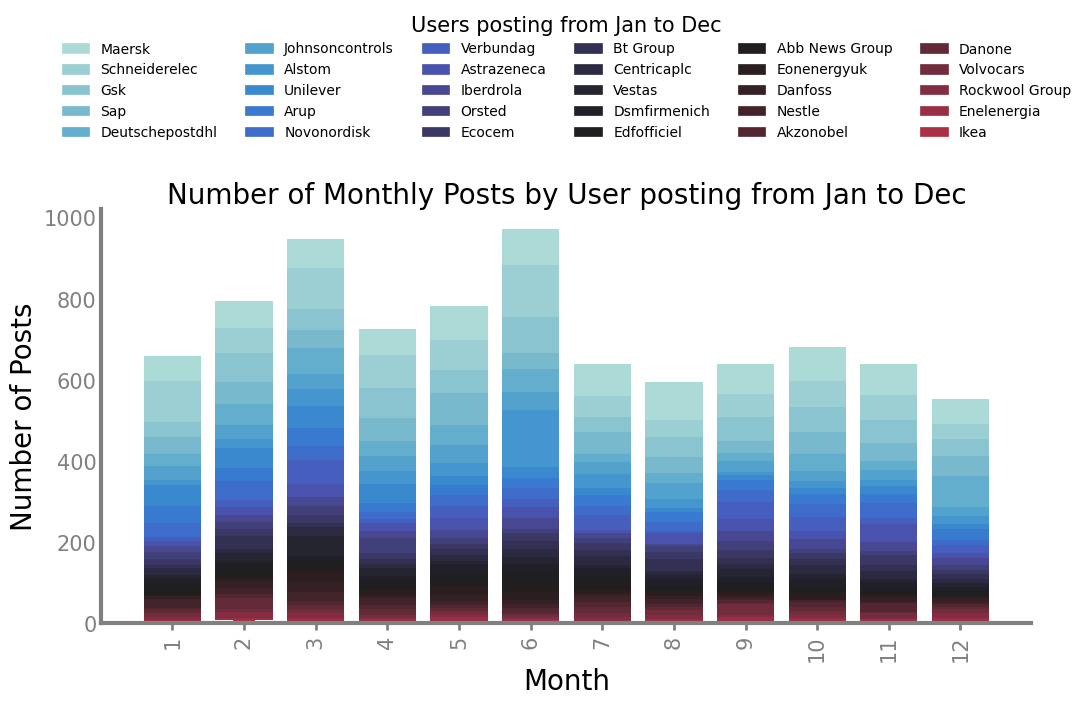

In [27]:
# Assuming 'df' is already defined and 'date' column is in datetime format
tmp = filtered_df.groupby(['month']).size()
df_plot = filtered_df.groupby(['month', 'username']).size().reset_index().pivot(columns='username', index='month', values=0)
df_plot = df_plot.fillna(value=0)
sorted_usernames = filtered_df.username.value_counts().index.to_list()

_, ax = plt.subplots(figsize=(12, 6))
for i in range(len(sorted_usernames)-1, -1, -1):
    if i == len(sorted_usernames)-1:
        ax.bar(x = df_plot[sorted_usernames[i]].index, height = df_plot[sorted_usernames[i]].values, width=0.3, color=icefire_palette[i])
        bottom = df_plot[sorted_usernames[i]].values.copy()
    else:
        ax.bar(x = df_plot[sorted_usernames[i]].index, height = df_plot[sorted_usernames[i]].values, bottom = bottom, width=0.8, color=icefire_palette[i])
        bottom += df_plot[sorted_usernames[i]].values.copy()

plt.title('Number of Monthly Posts by User posting from Jan to Dec')
plt.xlabel('Month')
plt.ylabel('Number of Posts')
plt.xticks(ticks = df_plot.index.to_list(), rotation=90)
plt.grid(False)

# tmp = df.groupby(['week']).size()
# window_size = 4 
# maverage = tmp.rolling(window=window_size).mean()
# std_dev = tmp.rolling(window=window_size).std()
# plt.plot(maverage, color='grey', linewidth=2, label='Trend (Moving Average)')
# plt.fill_between(tmp.index.to_list(), maverage-std_dev, maverage+std_dev, color='grey', alpha=0.3, label='Variance')

plt.subplots_adjust(top=0.8)  # Increase top margin
handles = [Patch(color=icefire_palette[i], label=sorted_usernames[i]) for i in range(len(sorted_usernames))]
labels = sorted_usernames
plt.legend(labels = labels, handles=handles, loc='upper center', bbox_to_anchor=(0.5, 1.5), ncol=6, frameon=False, title = 'Users posting from Jan to Dec')

plotname = '../data/out/figures/monthly_post_distribution_2023_by_user_filtered.png'
plt.savefig(plotname, dpi=600, bbox_inches='tight', facecolor='white')

#### Text length analysis

In [28]:
texts_df.text = texts_df.text.apply(lambda x: preliminary_cleaning(x))
texts_df['text_length'] = texts_df['text'].apply(len)
texts_df['date'] = pd.to_datetime(texts_df['created_at'], format='%Y-%m-%dT%H:%M:%S.%fZ')

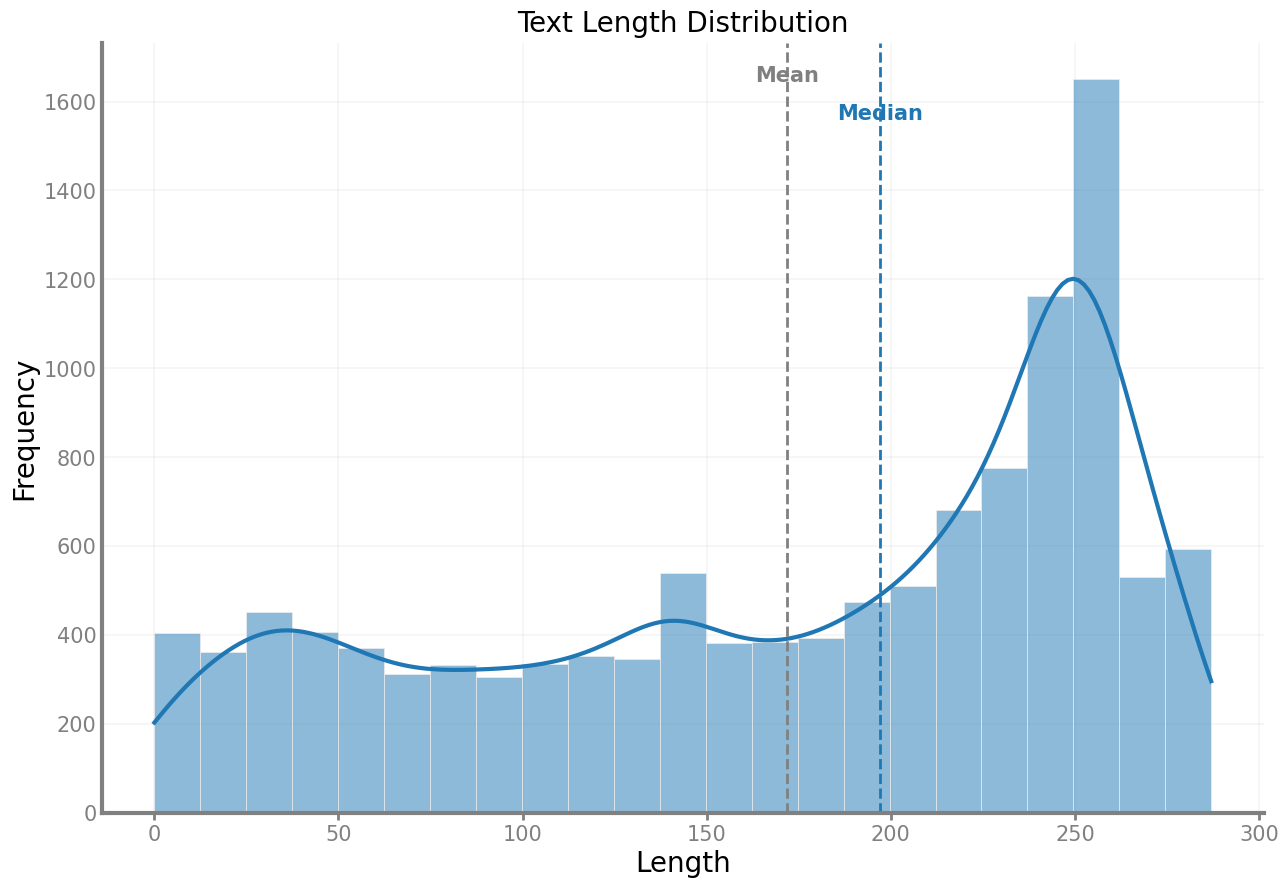

In [29]:
mean_text_length = texts_df.text_length.mean()
median_text_length = texts_df.text_length.median()

_, ax = plt.subplots(figsize=(15, 10))
g = sns.histplot(data=texts_df, x="text_length", kde=True, color='tab:blue', kde_kws={'cut':0})
plt.axvline(mean_text_length, color='grey', linestyle='--', linewidth=2)
plt.axvline(median_text_length, color='tab:blue', linestyle='--', linewidth=2)

# Add text annotations for the mean and median
plt.text(mean_text_length, plt.gca().get_ylim()[1] * 0.95, 'Mean', color='grey', ha='center', fontsize=15, weight='bold')
plt.text(median_text_length, plt.gca().get_ylim()[1] * 0.9, 'Median', color='tab:blue', ha='center', fontsize=15, weight='bold')

# Set x-axis label and its font size
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.title("Text Length Distribution", pad=8)

plotname = '../data/out/figures/text_length_distribution.png'
plt.savefig(plotname, dpi=600, bbox_inches='tight', facecolor='white')

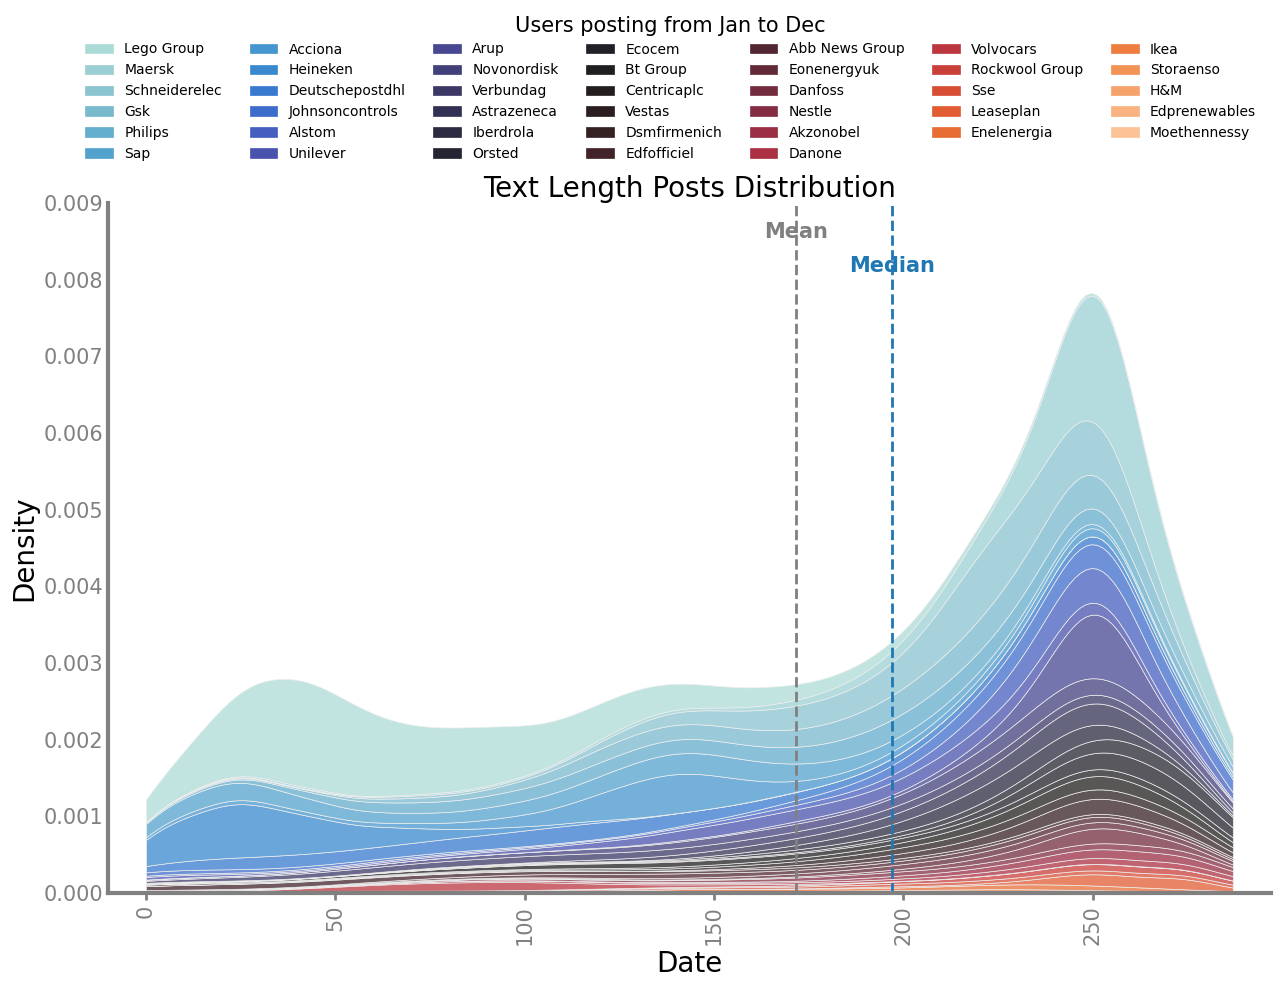

In [30]:
mean_text_length = texts_df.text_length.mean()
median_text_length = texts_df.text_length.median()

tweet_counts = texts_df['username'].value_counts()
sorted_usernames = tweet_counts.index.to_list()

_, ax = plt.subplots(figsize=(15, 10))
sns.kdeplot(data=texts_df, x="text_length", hue="username",  hue_order = sorted_usernames, multiple='stack', legend=False, cut=0, ax=ax, palette=icefire_palette)
ax.set_xticks(ticks=ax.get_xticks(), labels = ax.get_xticklabels(), rotation=90)
ax.set_yticks(ticks=ax.get_yticks(),  labels = ax.get_yticklabels())
ax.set_xlabel('Date')
ax.set_title('Text Length Posts Distribution')
ax.set_xlim(min(texts_df['text_length'])-10, max(texts_df['text_length'])+10)
ax.axvline(mean_text_length, color='grey', linestyle='--', linewidth=2)
ax.axvline(median_text_length, color='tab:blue', linestyle='--', linewidth=2)
ax.text(mean_text_length, plt.gca().get_ylim()[1] * 0.95, 'Mean', color='grey', ha='center', fontsize=15, weight='bold')
ax.text(median_text_length, plt.gca().get_ylim()[1] * 0.9, 'Median', color='tab:blue', ha='center', fontsize=15, weight='bold')

plt.subplots_adjust(top=0.8)  # Increase top margin
handles = [Patch(color=icefire_palette[i], label=sorted_usernames[i]) for i in range(len(sorted_usernames))]
labels = sorted_usernames
fig = plt.gcf()
fig_width = fig.get_size_inches()[0]  # Width of the figure in inches
max_legend_columns = int(fig_width // 2)  # Adjust the divisor to control column width
n_columns = min(len(sorted_usernames), max_legend_columns)
fig.legend(labels = labels, handles=handles, loc='upper center', bbox_to_anchor=(0.5, 1), ncol=n_columns, frameon=False, title = 'Users posting from Jan to Dec')

plt.grid(False)

plotname = '../data/out/figures/text_length_distribution_2023_by_user.png'
plt.savefig(plotname, dpi=600, bbox_inches='tight', facecolor='white')

I think that a lot of short texts are replies, so I will try to perform again the analysis I did before but without replies

In [34]:
len(df)

12050

In [35]:
def remove_replies(df, column_name='text'):
    # Use boolean indexing to filter out rows where the text starts with "@"
    filtered_df = df[~df[column_name].str.startswith('@')]
    return filtered_df

tmp = remove_replies(df)
tmp = tmp[['text', 'username']]
tmp.text = tmp.text.apply(lambda x: preliminary_cleaning(x))
tmp['text_length'] = tmp.text.apply(len)
tmp.head()

,text,username,text_length
0,new abb e-mobility home charging solution help...,Abb News Group,160
1,abb #technology to facilitate #energyefficienc...,Abb News Group,199
2,better decisions for a greener data center! ho...,Abb News Group,173
3,abb formula e season 9 goes green in mexico! t...,Abb News Group,258
4,the #abb decoded #podcast with frank muehlon i...,Abb News Group,254


In [36]:
len(tmp)

7932

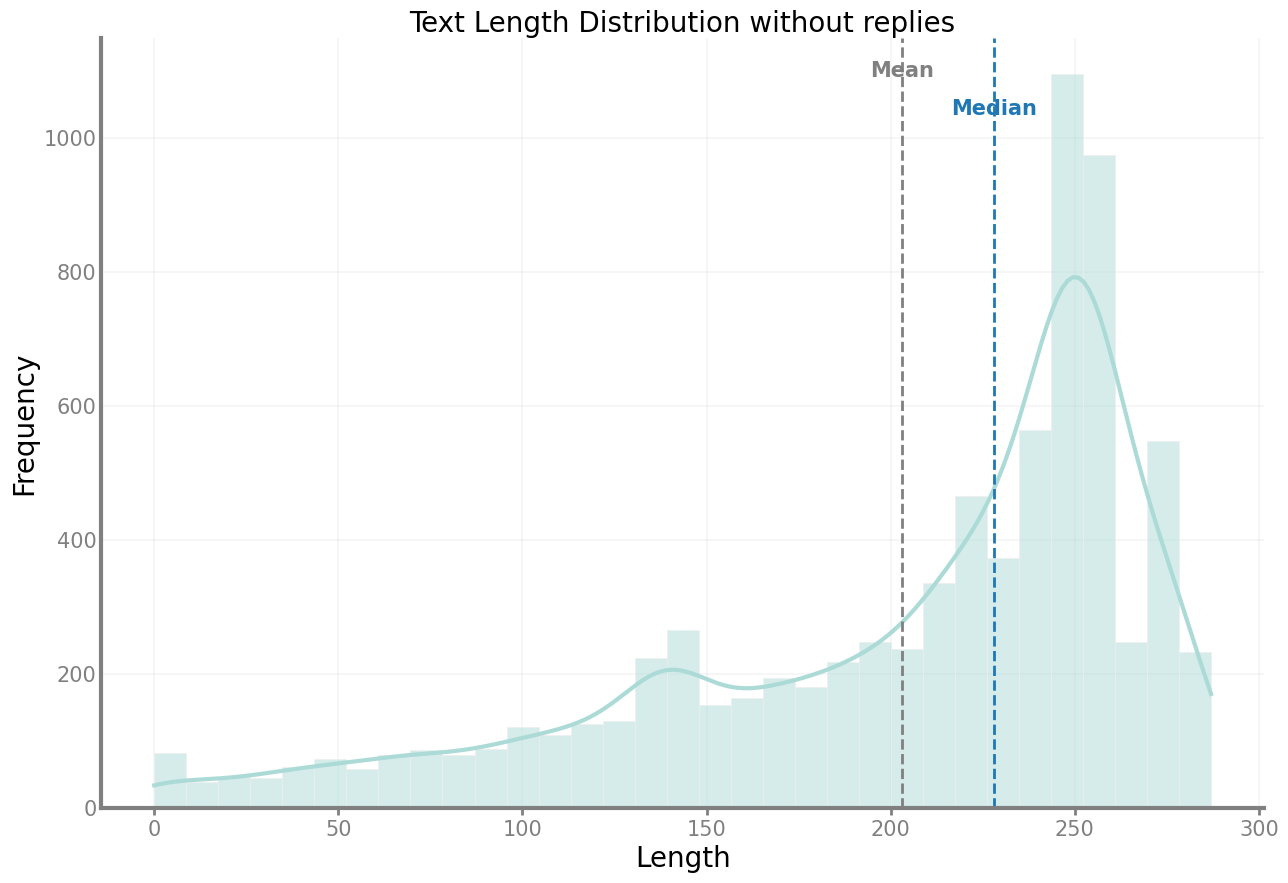

In [32]:
sns.set_palette("icefire", n_colors = len(tmp.username.unique()))

mean_text_length = tmp.text_length.mean()
median_text_length = tmp.text_length.median()

_, ax = plt.subplots(figsize=(15, 10))

# Create the KDE plot without the legend
g = sns.histplot(data=tmp, x="text_length", kde=True)
plt.axvline(mean_text_length, color='grey', linestyle='--', linewidth=2)
plt.axvline(median_text_length, color='tab:blue', linestyle='--', linewidth=2)

# Add text annotations for the mean and median
plt.text(mean_text_length, plt.gca().get_ylim()[1] * 0.95, 'Mean', color='grey', ha='center', fontsize=15, weight='bold')
plt.text(median_text_length, plt.gca().get_ylim()[1] * 0.9, 'Median', color='tab:blue', ha='center', fontsize=15, weight='bold')

# Set x-axis label and its font size
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.title("Text Length Distribution without replies")

plotname = '../data/out/figures/text_length_distribution_2023_without_replies.png'
plt.savefig(plotname, dpi=600, bbox_inches='tight', facecolor='white')


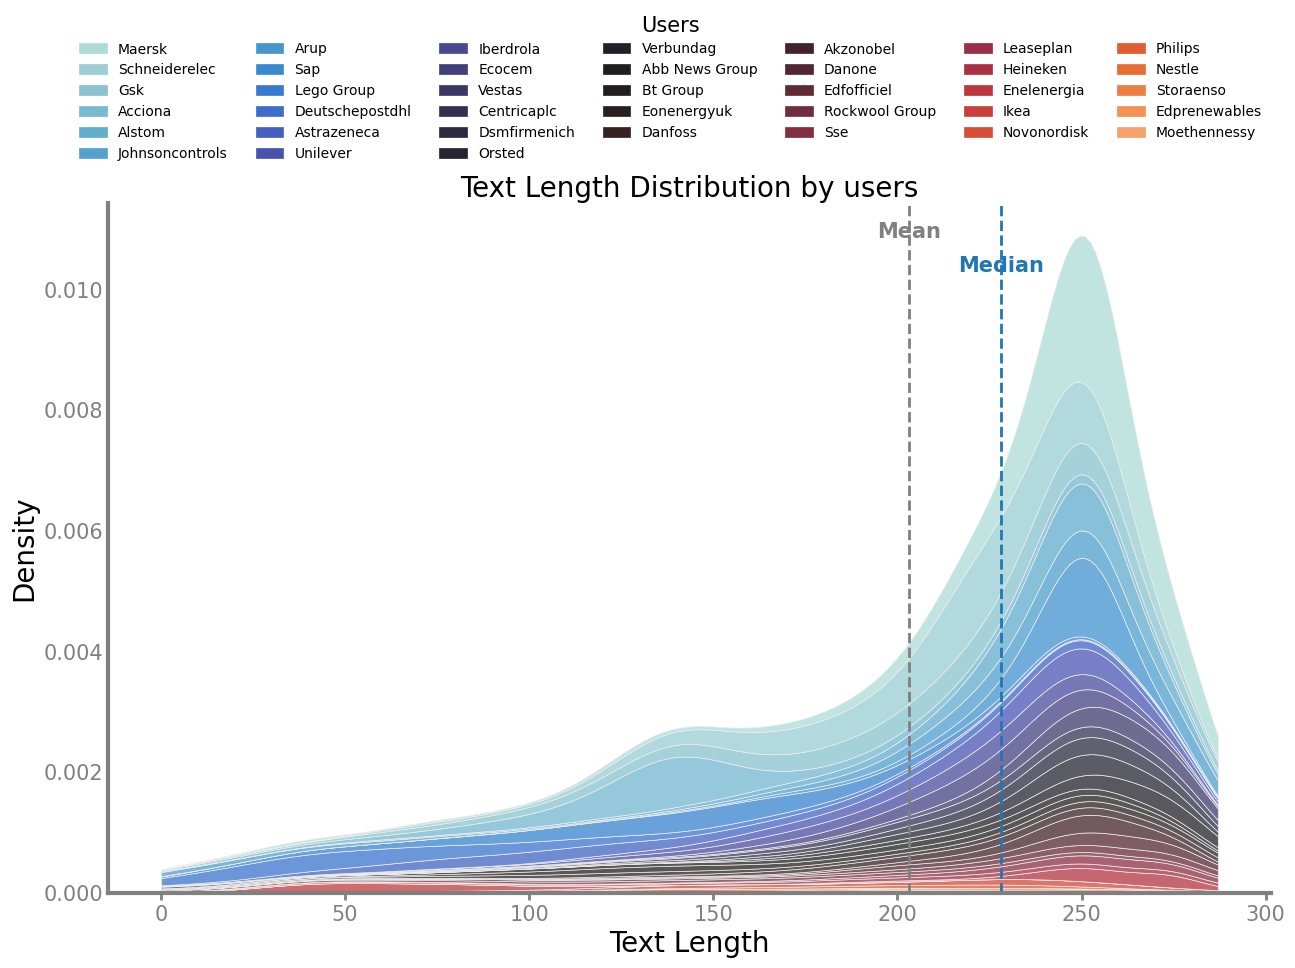

In [33]:
# Get unique usernames
sorted_usernames = tmp['username'].value_counts().index.to_list()

_, ax = plt.subplots(figsize=(15, 10))

# Create the KDE plot without the legend
g = sns.kdeplot(data=tmp, x="text_length", hue="username", hue_order=sorted_usernames, multiple="stack", legend=False, cut=0)

plt.axvline(mean_text_length, color='grey', linestyle='--', linewidth=2)
plt.axvline(median_text_length, color='tab:blue', linestyle='--', linewidth=2)

# Add text annotations for the mean and median
plt.text(mean_text_length, plt.gca().get_ylim()[1] * 0.95, 'Mean', color='grey', ha='center', fontsize=15, weight='bold')
plt.text(median_text_length, plt.gca().get_ylim()[1] * 0.9, 'Median', color='tab:blue', ha='center', fontsize=15, weight='bold')

labels = sorted_usernames
handles = [Patch(color=icefire_palette[i], label=sorted_usernames[i]) for i in range(len(sorted_usernames))]
fig = plt.gcf()
fig_width = fig.get_size_inches()[0] 
max_legend_columns = int(fig_width // 2) 
n_columns = min(len(sorted_usernames), max_legend_columns)
plt.subplots_adjust(top=0.8)
fig.legend(labels = labels, handles=handles, loc='upper center', bbox_to_anchor=(0.5, 1), ncol=n_columns, frameon=False, title='Users')

plt.xlabel('Text Length')
plt.ylabel('Density')
plt.title('Text Length Distribution by users')
plt.grid(False)

plotname = '../data/out/figures/text_length_distribution_2023_without_replies_by_users.png'
plt.savefig(plotname, dpi=600, bbox_inches='tight', facecolor='white')
